In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round'])

In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                 53
winner_hand              0
winner_ht               79
winner_age               3
loser_hand               1
loser_ht               227
loser_age                3
minutes               1033
w_ace                  694
w_df                   694
w_svpt                 694
w_1stIn                694
w_1stWon               694
w_2ndWon               694
w_SvGms                694
w_bpSaved              694
w_bpFaced              694
l_ace                  694
l_df                   694
l_svpt                 694
l_1stIn                694
l_1stWon               694
l_2ndWon               694
l_SvGms                694
l_bpSaved              694
l_bpFaced              694
winner_rank             79
winner_rank_points      79
loser_rank             222
loser_rank_points      222
dtype: int64
2
17547


## Convert Categorical Variables to Numerical

In [5]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
# df['round'] = round_encoder.fit_transform(df['round'])

In [6]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',
    'w_SvGms': 'p1_SvGms',
    'w_bpSaved': 'p1_bpSaved',
    'w_bpFaced': 'p1_bpFaced',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
    'l_SvGms': 'p2_SvGms',
    'l_bpSaved': 'p2_bpSaved',
    'l_bpFaced': 'p2_bpFaced'
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
0    8826
1    8721
Name: count, dtype: int64


In [7]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,185.0,25.6,1,188.0,30.6,123.0,9.0,2.0,...,33.0,19.0,14.0,1.0,4.0,47.0,1010.0,52.0,909.0,0
1,2,1,188.0,21.2,1,183.0,23.7,90.0,5.0,3.0,...,25.0,7.0,9.0,7.0,11.0,54.0,890.0,94.0,593.0,0
2,2,1,175.0,25.6,1,185.0,31.3,145.0,8.0,6.0,...,48.0,12.0,14.0,9.0,11.0,30.0,1391.0,63.0,809.0,1
3,2,1,183.0,18.8,1,188.0,28.0,104.0,9.0,3.0,...,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0,0
4,2,0,193.0,27.2,1,188.0,19.9,69.0,4.0,0.0,...,32.0,11.0,10.0,3.0,3.0,68.0,755.0,175.0,299.0,1


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,175.0,25.0,1,183.0,28.2,87.0,1.0,2.0,...,19.0,5.0,8.0,5.0,9.0,569.0,64.0,819.0,24.0,0
3066,2,1,188.0,28.8,1,178.0,31.0,65.0,3.0,2.0,...,30.0,11.0,9.0,4.0,4.0,900.0,18.0,279.0,205.0,1
3068,0,0,185.0,23.9,1,188.0,21.8,137.0,1.0,2.0,...,24.0,18.0,12.0,8.0,16.0,616.0,55.0,740.0,34.0,0
3070,0,0,185.0,23.9,1,175.0,34.2,95.0,1.0,1.0,...,19.0,14.0,8.0,3.0,4.0,616.0,55.0,136.0,489.0,1
3074,2,1,185.0,27.3,1,175.0,26.9,159.0,5.0,3.0,...,41.0,13.0,14.0,2.0,5.0,416.0,109.0,554.0,67.0,1


<class 'pandas.core.frame.DataFrame'>
Index: 17547 entries, 0 to 3074
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17547 non-null  int32  
 1   p1_hand         17547 non-null  int32  
 2   p1_ht           17547 non-null  float64
 3   p1_age          17547 non-null  float64
 4   p2_hand         17547 non-null  int32  
 5   p2_ht           17547 non-null  float64
 6   p2_age          17547 non-null  float64
 7   minutes         17547 non-null  float64
 8   p1_ace          17547 non-null  float64
 9   p1_df           17547 non-null  float64
 10  p1_svpt         17547 non-null  float64
 11  p1_1stIn        17547 non-null  float64
 12  p1_1stWon       17547 non-null  float64
 13  p1_2ndWon       17547 non-null  float64
 14  p1_SvGms        17547 non-null  float64
 15  p1_bpSaved      17547 non-null  float64
 16  p1_bpFaced      17547 non-null  float64
 17  p2_ace          17547 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,1.304383,0.859007,187.187667,27.133755,0.862256,187.269790,27.141329,115.207215,6.340742,2.929732,...,35.898159,15.480880,12.623411,4.102582,6.711062,79.095572,1532.481222,79.935716,1524.854163,0.497008
std,0.893933,0.348024,7.242471,4.574586,0.344641,6.947036,4.570164,42.268962,5.445175,2.437201,...,14.156143,6.857327,4.220184,3.239652,4.417920,108.587840,1730.985741,107.615621,1717.318176,0.500005
min,0.000000,0.000000,15.000000,16.400000,0.000000,163.000000,16.500000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.000000,183.000000,23.600000,1.000000,183.000000,23.600000,83.000000,2.000000,1.000000,...,26.000000,11.000000,10.000000,2.000000,3.000000,26.000000,648.500000,26.000000,640.000000,0.000000
50%,2.000000,1.000000,188.000000,26.700000,1.000000,188.000000,26.800000,108.000000,5.000000,2.000000,...,34.000000,14.000000,12.000000,3.000000,6.000000,55.000000,948.000000,55.000000,950.000000,0.000000
75%,2.000000,1.000000,193.000000,30.300000,1.000000,193.000000,30.300000,139.000000,9.000000,4.000000,...,44.000000,19.000000,15.000000,6.000000,9.000000,94.000000,1640.000000,94.000000,1630.000000,1.000000
max,2.000000,1.000000,211.000000,41.800000,1.000000,211.000000,42.500000,396.000000,61.000000,25.000000,...,171.000000,56.000000,50.000000,27.000000,35.000000,2146.000000,12415.000000,1821.000000,12415.000000,1.000000


In [8]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
minutes           0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p1_SvGms          0
p1_bpSaved        0
p1_bpFaced        0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p2_SvGms          0
p2_bpSaved        0
p2_bpFaced        0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


## Drop Nulls

In [9]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17547


## Scale Features

In [10]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([0, 0, 1, ..., 0, 1, 1])

array([[ 0.77817611,  0.40513522, -0.30206954, ..., -0.30184888,
        -0.25959532, -0.35862412],
       [ 0.77817611,  0.40513522,  0.11216556, ..., -0.37117552,
         0.13069372, -0.54263719],
       [ 0.77817611,  0.40513522, -1.68285318, ..., -0.08173681,
        -0.15737676, -0.4168561 ],
       ...,
       [-1.45919178, -2.4683117 , -0.30206954, ..., -0.85357337,
         6.13371079, -0.868154  ],
       [-1.45919178, -2.4683117 , -0.30206954, ..., -0.85357337,
         0.52098275, -0.60319846],
       [ 0.77817611,  0.40513522, -0.30206954, ..., -0.82237638,
         4.40528792, -0.84893745]])

## Split data into testing and training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([0, 1, 0, ..., 1, 0, 1])

### Reusable function for evaluation

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(y_pred_test, y_pred_train):
  print("=== Test Metrics ===")
  accuracy_test = accuracy_score(y_test, y_pred_test)
  print(f"Accuracy: {accuracy_test}")

  precision_test = precision_score(y_test, y_pred_test, average='binary')
  print(f"Precision: {precision_test}")

  recall_test = recall_score(y_test, y_pred_test, average='binary')
  print(f"Recall: {recall_test}")

  f1_test = f1_score(y_test, y_pred_test, average='binary')
  print(f"F1 Score: {f1_test}")

  print("\n=== Training Metrics ===")
  accuracy_train = accuracy_score(y_train, y_pred_train)
  print(f"Accuracy: {accuracy_train}")

  precision_train = precision_score(y_train, y_pred_train, average='binary')
  print(f"Precision: {precision_train}")

  recall_train = recall_score(y_train, y_pred_train, average='binary')
  print(f"Recall: {recall_train}")

  f1_train = f1_score(y_train, y_pred_train, average='binary')
  print(f"F1 Score: {f1_train}")

  # Show the shape of training data
  print("\nX_train shape:", X_train.shape)

  # Confusion matrix for test data
  cm = confusion_matrix(y_test, y_pred_test)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.title('Confusion Matrix (Test Data)')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.947008547008547
Precision: 0.9426229508196722
Recall: 0.9481743227326266
F1 Score: 0.9453904873752202

=== Training Metrics ===
Accuracy: 0.9519840421742538
Precision: 0.9527884752531736
Recall: 0.9511604727324505
F1 Score: 0.9519737779677925

X_train shape: (14037, 30)


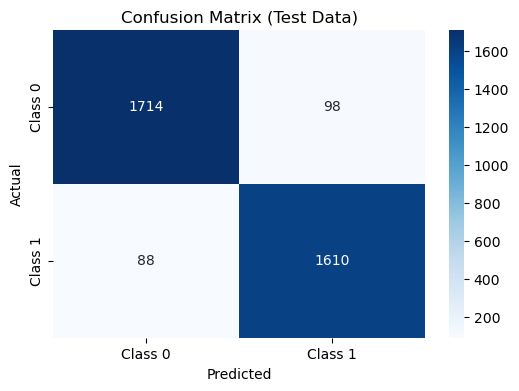

In [13]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9467236467236467
Precision: 0.942589338019918
Recall: 0.947585394581861
F1 Score: 0.9450807635829662

=== Training Metrics ===
Accuracy: 0.9518415615872338
Precision: 0.9523877405559515
Recall: 0.9513028620247758
F1 Score: 0.951844992164126

X_train shape: (14037, 30)


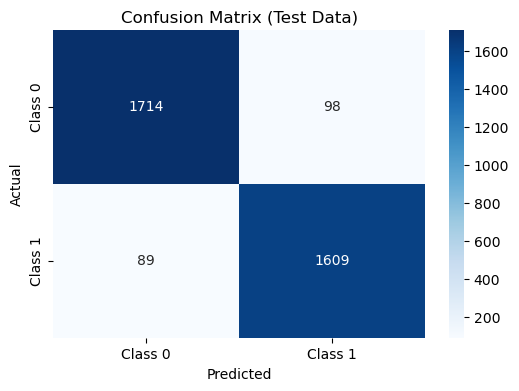

In [14]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9276353276353276
Precision: 0.9158986175115207
Recall: 0.9363957597173145
F1 Score: 0.926033779848573

=== Training Metrics ===
Accuracy: 0.9354562940799316
Precision: 0.9347547974413646
Recall: 0.9363519863306279
F1 Score: 0.9355527102005975

X_train shape: (14037, 30)


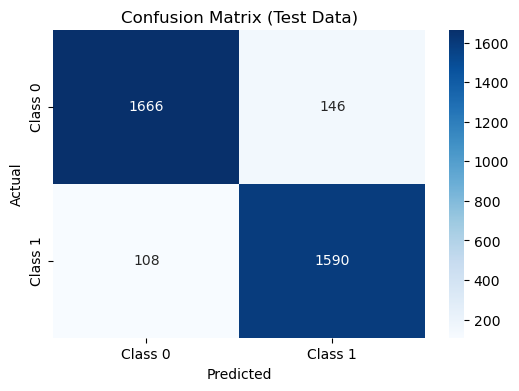

In [15]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model 
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method
running the RFE wrapper method recursively until the percision value begins decreasing from the elimination of Features within the dataset

In [16]:
# 1. Compute baseline F1 with all features
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")


Baseline F1: 0.9454
→ Stopping: dropping 'p2_df' drops F1 from 0.9454 to 0.9448

Total removed: 1 features
Features removed (in order):
 - p2_df


## DecisionTreeClassifier

=== Test Metrics ===
Accuracy: 0.764102564102564
Precision: 0.7075381679389313
Recall: 0.8733804475853946
F1 Score: 0.7817606747496046

=== Training Metrics ===
Accuracy: 0.7802236945216214
Precision: 0.7300771208226221
Recall: 0.8896482984479567
F1 Score: 0.8020024388678518

X_train shape: (14037, 30)


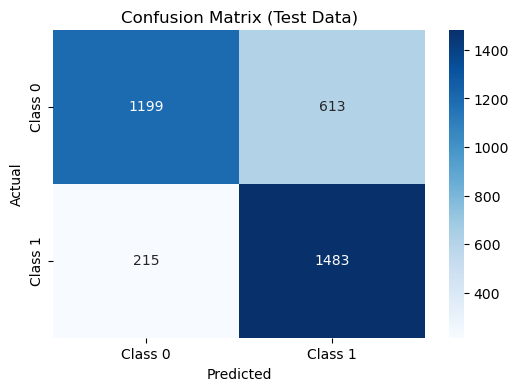

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.7991452991452992
Precision: 0.7750692520775623
Recall: 0.8239104829210836
F1 Score: 0.7987439337710533

=== Training Metrics ===
Accuracy: 0.807508726935955
Precision: 0.7935860850659057
Recall: 0.8315534671792681
F1 Score: 0.8121262689472952

X_train shape: (14037, 30)


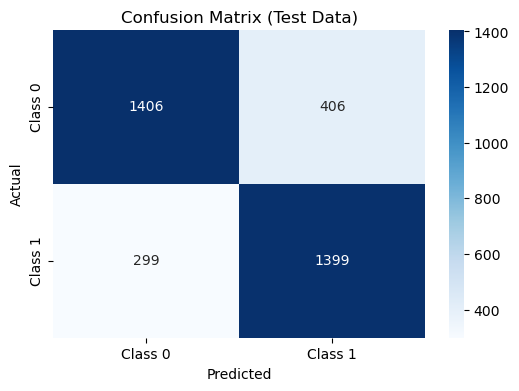

In [18]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9210826210826211
Precision: 0.9157401989467525
Recall: 0.9216725559481743
F1 Score: 0.918696800704432

=== Training Metrics ===
Accuracy: 0.9650922561800954
Precision: 0.9661766804623948
Recall: 0.96397550904172
F1 Score: 0.9650748396293657

X_train shape: (14037, 30)


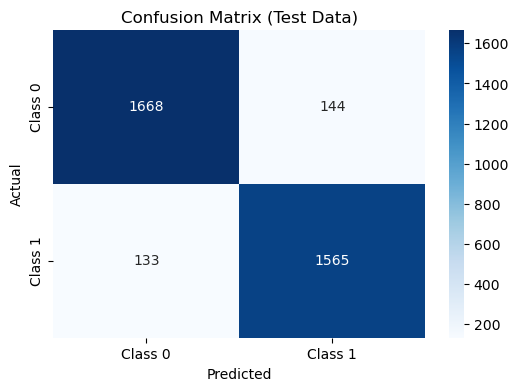

In [19]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [20]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")


Baseline F1: 0.7818
Removed 'surface' → new F1 = 0.7818
Removed 'p1_hand' → new F1 = 0.7818
Removed 'p1_ht' → new F1 = 0.7818
Removed 'p1_age' → new F1 = 0.7818
Removed 'p2_hand' → new F1 = 0.7818
Removed 'p2_ht' → new F1 = 0.7818
Removed 'p2_age' → new F1 = 0.7818
Removed 'minutes' → new F1 = 0.7818
Removed 'p1_ace' → new F1 = 0.7818
Removed 'p1_df' → new F1 = 0.7818
Removed 'p1_svpt' → new F1 = 0.7818
Removed 'p1_1stIn' → new F1 = 0.7818
Removed 'p2_1stIn' → new F1 = 0.7818
Removed 'p2_rank_points' → new F1 = 0.7818
Removed 'p1_SvGms' → new F1 = 0.7818
Removed 'p2_ace' → new F1 = 0.7818
Removed 'p2_df' → new F1 = 0.7818
Removed 'p2_svpt' → new F1 = 0.7818
Removed 'p2_SvGms' → new F1 = 0.7818
Removed 'p1_rank' → new F1 = 0.7818
Removed 'p1_rank_points' → new F1 = 0.7818
Removed 'p2_rank' → new F1 = 0.7818
Removed 'p2_2ndWon' → new F1 = 0.7818
Removed 'p1_2ndWon' → new F1 = 0.7818
→ Stopping: dropping 'p2_bpSaved' drops F1 from 0.7818 to 0.7796

Total removed: 25 features
Features remo

## Random Forest

=== Test Metrics ===
Accuracy: 0.8643874643874644
Precision: 0.8503440366972477
Recall: 0.8733804475853946
F1 Score: 0.8617083091226031

=== Training Metrics ===
Accuracy: 0.9331766046876113
Precision: 0.9326034409213707
Recall: 0.9339313683610992
F1 Score: 0.9332669322709163

X_train shape: (14037, 30)


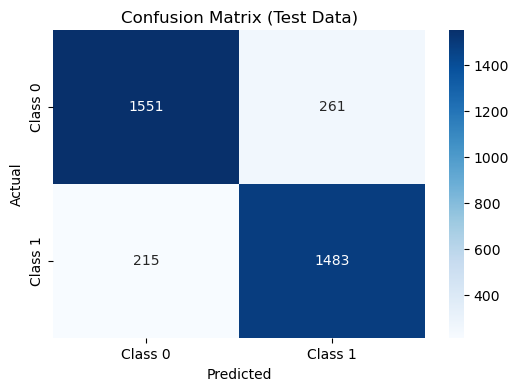

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.860968660968661
Precision: 0.8481012658227848
Recall: 0.8680800942285041
F1 Score: 0.8579743888242142

=== Training Metrics ===
Accuracy: 0.9240578471183302
Precision: 0.9230222979690385
Recall: 0.9253880108215862
F1 Score: 0.9242036405005688

X_train shape: (14037, 30)


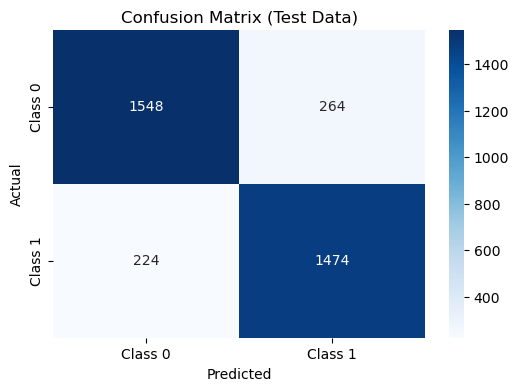

In [22]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.8997150997150997
Precision: 0.8963486454652533
Recall: 0.8963486454652533
F1 Score: 0.8963486454652533

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


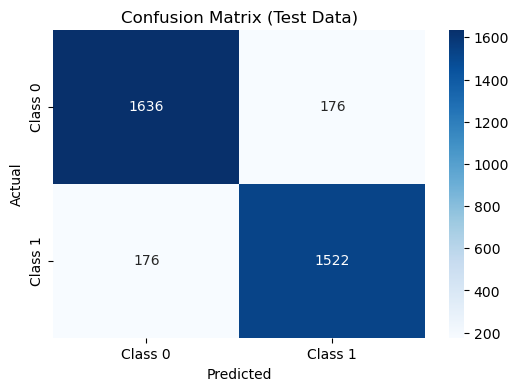

In [23]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [24]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")


Baseline F1: 0.8617
→ Stopping: dropping 'p1_hand' drops F1 from 0.8617 to 0.8586

Total removed: 1 features
Features removed (in order):
 - p1_hand


## KNN

=== Test Metrics ===
Accuracy: 0.8188034188034188
Precision: 0.8123529411764706
Recall: 0.8133097762073027
F1 Score: 0.8128310771041789

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


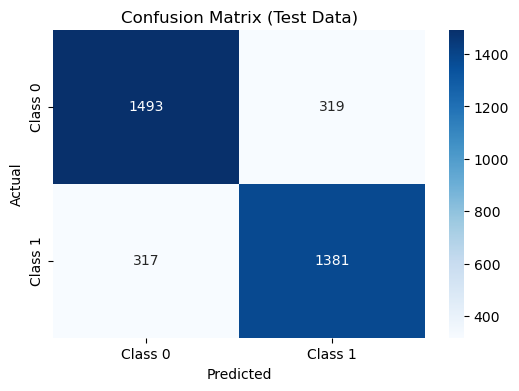

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.860968660968661
Precision: 0.8481012658227848
Recall: 0.8680800942285041
F1 Score: 0.8579743888242142

=== Training Metrics ===
Accuracy: 0.9240578471183302
Precision: 0.9230222979690385
Recall: 0.9253880108215862
F1 Score: 0.9242036405005688

X_train shape: (14037, 30)


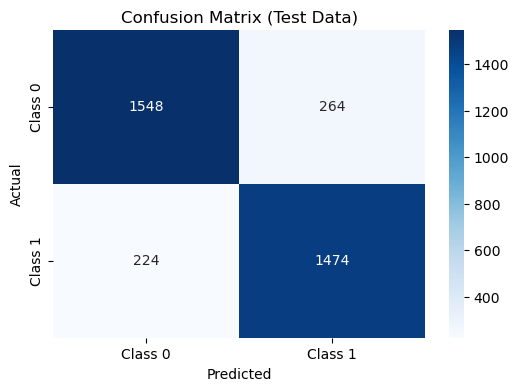

In [26]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.8997150997150997
Precision: 0.8963486454652533
Recall: 0.8963486454652533
F1 Score: 0.8963486454652533

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


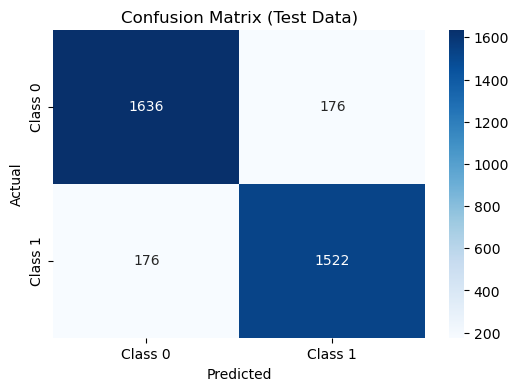

In [27]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method

In [28]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")


Baseline F1: 0.8617
→ Stopping: dropping 'p1_hand' drops F1 from 0.8617 to 0.8586

Total removed: 1 features
Features removed (in order):
 - p1_hand


## Ball Tree

## KD Tree

## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.9458689458689459
Precision: 0.9404205607476636
Recall: 0.9481743227326266
F1 Score: 0.9442815249266863

=== Training Metrics ===
Accuracy: 0.9523402436418038
Precision: 0.9535979440319817
Recall: 0.9510180834401253
F1 Score: 0.9523062664860626

X_train shape: (14037, 30)


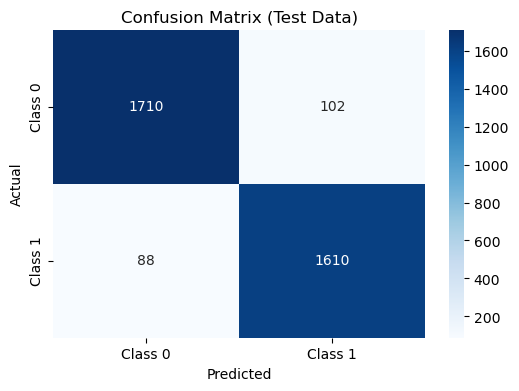

In [29]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9458689458689459
Precision: 0.9409356725146198
Recall: 0.947585394581861
F1 Score: 0.9442488262910798

=== Training Metrics ===
Accuracy: 0.9517703212937237
Precision: 0.9535448827901658
Recall: 0.9498789691015236
F1 Score: 0.9517083957486269

X_train shape: (14037, 30)


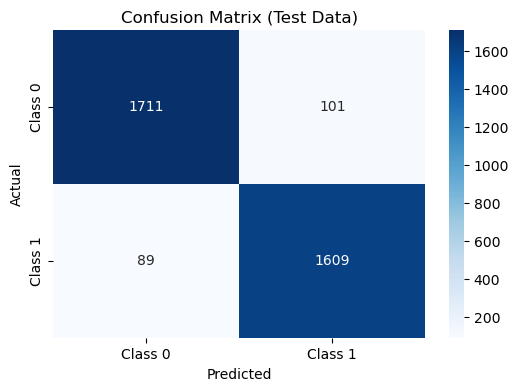

In [30]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9344729344729344
Precision: 0.9272409778812573
Recall: 0.9381625441696113
F1 Score: 0.9326697892271663

=== Training Metrics ===
Accuracy: 0.9367386193631118
Precision: 0.9399110856159473
Recall: 0.9332194218994732
F1 Score: 0.9365533009431266

X_train shape: (14037, 30)


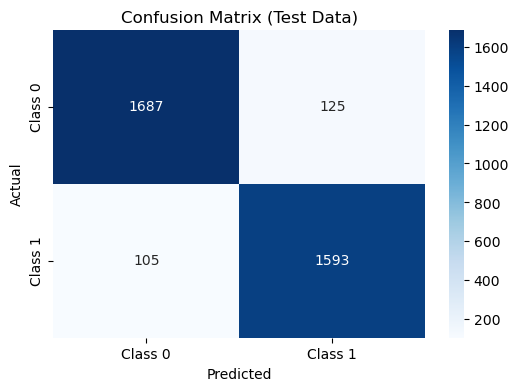

In [31]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, algorithm="SAMME", random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method

In [32]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")


Baseline F1: 0.9443
Removed 'p2_hand' → new F1 = 0.9443
→ Stopping: dropping 'p2_ht' drops F1 from 0.9443 to 0.9440

Total removed: 2 features
Features removed (in order):
 - p2_hand
 - p2_ht


## SVM Gaussian Kernel

=== Test Metrics ===
Accuracy: 0.9407407407407408
Precision: 0.935672514619883
Recall: 0.9422850412249706
F1 Score: 0.9389671361502347

=== Training Metrics ===
Accuracy: 0.9631687682553252
Precision: 0.9643163003140166
Recall: 0.961982058949167
F1 Score: 0.9631477653432177

X_train shape: (14037, 30)


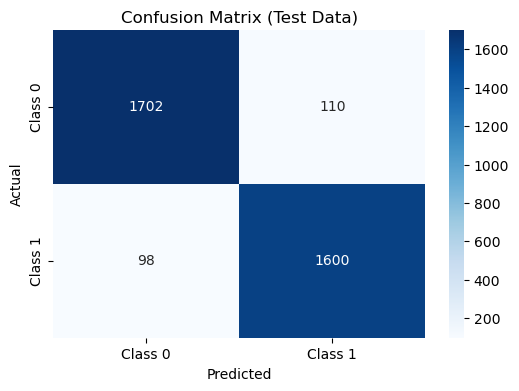

In [33]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9413105413105413
Precision: 0.9408983451536643
Recall: 0.9375736160188457
F1 Score: 0.9392330383480826

=== Training Metrics ===
Accuracy: 0.961530241504595
Precision: 0.9666042896214193
Recall: 0.9561440979638332
F1 Score: 0.9613457408732999

X_train shape: (14037, 30)


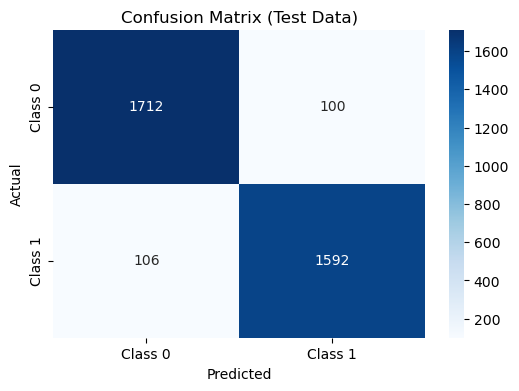

In [34]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

# Note: Boosting results in the model predicting all 1s

## Wrapper Method

In [35]:
def perm_importance_getter(est):
    importance = permutation_importance(est, X_train, y_train, n_repeats=5, random_state=0)
    return importance.importances_mean


baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    selector = RFE(
        estimator=clf,
        n_features_to_select=len(features) - 1,
        importance_getter=perm_importance_getter
    )
    selector.fit(current_X_train, y_train)

    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from "
              f"{baseline_f1:.4f} to {new_f1:.4f}")
        break

    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # shrink for next iteration
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5) summary
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")


Baseline F1: 0.9390
→ Stopping: dropping 'minutes' drops F1 from 0.9390 to 0.9380

Total removed: 1 features
Features removed (in order):
 - minutes


## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

=== Test Metrics ===
Accuracy: 0.8706552706552707
Precision: 0.8637426900584795
Recall: 0.8698468786808009
F1 Score: 0.8667840375586855

=== Training Metrics ===
Accuracy: 0.9909524827242289
Precision: 0.9921495860690837
Recall: 0.9897479709525844
F1 Score: 0.9909473234015254

X_train shape: (14037, 30)


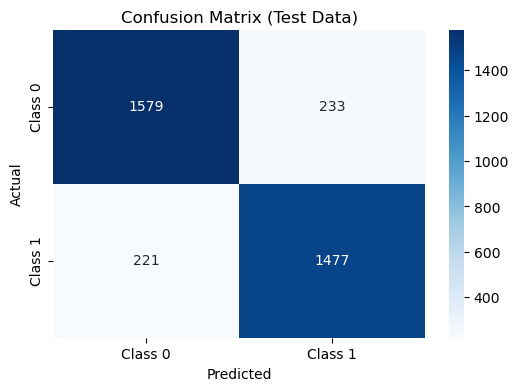

In [36]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Logistic & KNN -> Decision Tree

=== Test Metrics ===
Accuracy: 0.9247863247863248
Precision: 0.9202813599062134
Recall: 0.9246171967020024
F1 Score: 0.9224441833137486

=== Training Metrics ===
Accuracy: 0.9450024934102729
Precision: 0.9559445660102115
Recall: 0.9330770326071479
F1 Score: 0.9443723879521545

X_train shape: (14037, 30)


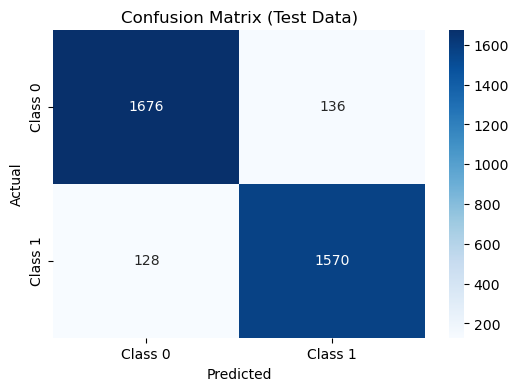

In [37]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Gaussian SVC & Decision Tree -> Logistic

=== Test Metrics ===
Accuracy: 0.9404558404558404
Precision: 0.9351256575102279
Recall: 0.9422850412249706
F1 Score: 0.9386916984452919

=== Training Metrics ===
Accuracy: 0.9634537294293652
Precision: 0.9646017699115044
Recall: 0.9622668375338175
F1 Score: 0.9634328890156105

X_train shape: (14037, 30)


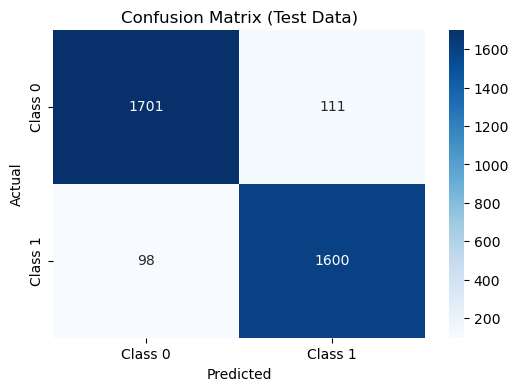

In [38]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)